In [1]:
#!unxz mnist.out.xz

In [2]:
from model import Model
from collections import namedtuple
import sys
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
random.seed(1)
np.random.seed(1)

Game = namedtuple('Game', ['env_name', 'input_size', 'output_size', 'wann_file', 'action_select', 'weight_bias'])
game = Game(env_name='MNISTTEST784-v0',
  input_size=784,
  output_size=10,
  wann_file='brain-tokyo-workshop/WANNRelease/WANNTool/champions/mnist784_best.out',
  action_select='softmax', # all, soft, hard
  weight_bias=0.0,
)
model = Model(game)
model.make_env()
model.env.seed(1)
model.load_model('brain-tokyo-workshop/WANNRelease/WANNTool/log/mnist784test.cma.4.32.best.json')

batch = model.env.reset()
output = model.get_action(batch)

loading file brain-tokyo-workshop/WANNRelease/WANNTool/log/mnist784test.cma.4.32.best.json


In [4]:
import os
import numpy as np
from skimage.transform import resize

MASK_PATH = os.path.join('rise_masks.npy')

#MASK_COUNT = 500
#s = 8
#p1 = 0.5

MASK_COUNT = 5000
s = 8
p1 = 0.5

def generate_masks(N, s, p1, input_size):
    cell_size = np.ceil(np.array(input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *input_size))

    for i in range(N):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + input_size[0], y:y + input_size[1]]
    masks = masks.reshape(-1, *input_size, 1)
    return masks


def explain(model, inp, masks, input_size):
    batch_size = 100
    preds = []
    # Make sure multiplication is being done for correct axes

    for i in range(0, MASK_COUNT, batch_size):
        sub_masks = masks[i:min(i + batch_size, MASK_COUNT)]
        masked = inp * sub_masks
        o = model.get_action(masked.reshape(batch_size, 28 * 28))
        preds.append(o)
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(MASK_COUNT, -1)).reshape(-1, *input_size)
    sal = sal / MASK_COUNT / p1
    return sal


masks = generate_masks(MASK_COUNT, s, p1, (28, 28))

label: 6
prediction 6


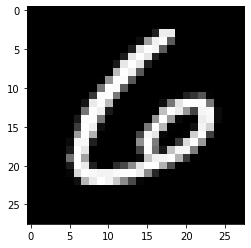

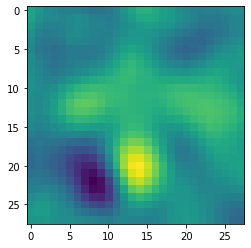

label: 9
prediction 9


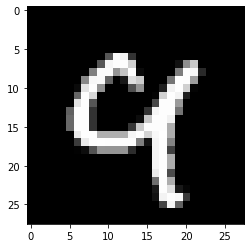

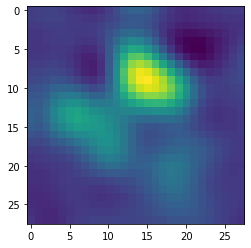

label: 2
prediction 2


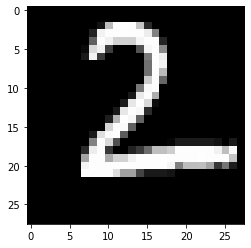

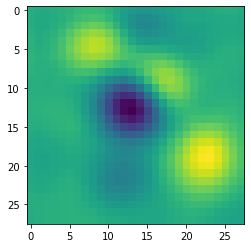

label: 6
prediction 6


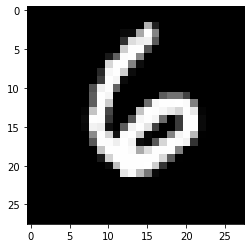

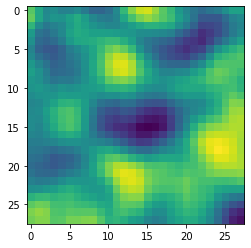

label: 7
prediction 7


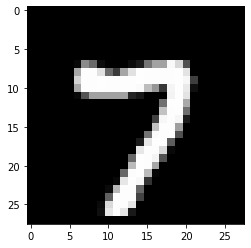

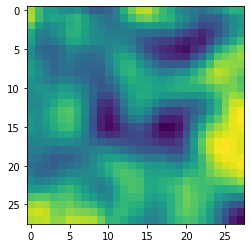

label: 6
prediction 6


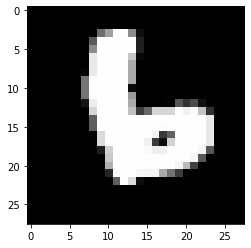

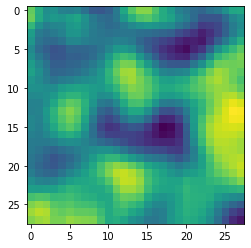

label: 1
prediction 1


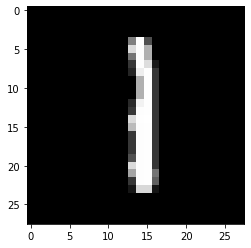

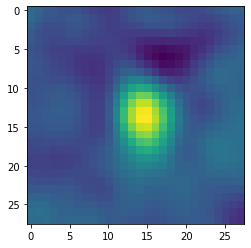

label: 4
prediction 9


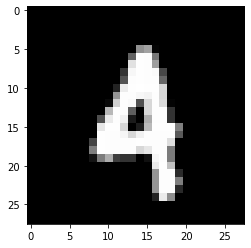

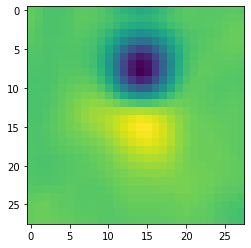

label: 7
prediction 7


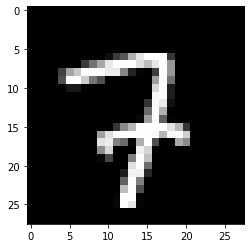

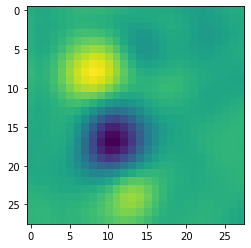

label: 1
prediction 1


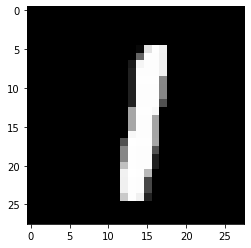

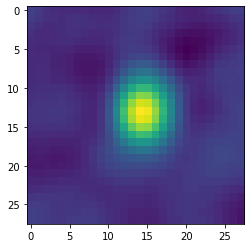

In [5]:
for index in range(10):
    image = batch[index]

    label = model.env.target[model.env.currIndx][index]
    print('label:', label)

    baseline = model.get_action([batch[index]])

    print('prediction', np.argmax(baseline[0]))

    sal = explain(model, image.reshape(28, 28, 1), masks, (28, 28))

    plt.imshow(image.reshape(28, 28), cmap='Greys_r')
    plt.show()

    img = plt.imshow(sal[label])
    plt.show()